# Search for phase transition details for benchmark point

This notebook searches for the details of the dynamics of the phase transition for a certain benchmark point. Both 1d and 2d cases are considered.

In [2]:
import numpy as np
from scipy import optimize
from cosmoTransitions import generic_potential as gp
from cosmoTransitions import pathDeformation as pd

In [3]:
import matplotlib.pyplot as plt

## Prepare

### Constants
- $m_H$ = 125. GeV
- $v_{EW}$ = 174. GeV

In [4]:
GF = 1.16637e-05
v = 1/(np.sqrt(2*np.sqrt(2)*GF))
mHSM = 125.13

### Transfer physical parameters to bare parameters
$$
\begin{align*}
\mu_H^2 &= \frac{1}{2}(m_h^2 \cos^2 \theta + m_S^2 \sin^2 \theta)\\
\mu_S^2 &= m_h^2 \sin^2 \theta + m_S^2 \cos^2 \theta\\
A &= \frac{(m_h^2 - m_S^2)\sin \theta \cos \theta}{\sqrt{2}v}\\
\lambda &= \frac{m_h^2 \cos^2 \theta + m_S^2 \sin^2 \theta}{4 v^2}
\end{align*}
$$


In [5]:
def muH2(mS, sintheta):
    """\mu_H square"""
    return 0.5*(mHSM**2 * (1-sintheta**2) + mS**2 * sintheta**2)

def muS2(mS, sintheta):
    """\mu_S square"""
    return sintheta**2 * mHSM**2 + (1 - sintheta**2) * mS**2

def A(mS, sintheta):
    """A parameter"""
    nominator = (mHSM**2 - mS**2) * sintheta * np.sqrt(1-sintheta**2)
    denominator = np.sqrt(2) * v
    return nominator/denominator

def lm(mS, sintheta):
    """\lambda parameter"""
    nominator = (1 - sintheta**2)*mHSM**2 + sintheta**2 * mS**2
    return nominator/(4*v**2)

## Define effective potential

Here we define the effective potential for both 1d and 2d case.

In [6]:
class model(gp.generic_potential):
    def init(self, mS, sintheta):
        self.Ndim = 2
        self.Tmax = 100
        self.mS = mS
        self.sintheta = sintheta
        self.lm = lm(self.mS, self.sintheta)
        self.A = A(self.mS,self.sintheta)
        self.muH2 = muH2(self.mS,self.sintheta)
        self.muS2 = muS2(self.mS,self.sintheta)
        self.g = 0.65
        self.gY = 0.36
        self.yt = 0.9945
        self.D = (3*self.g**2 + self.gY**2 + 4*self.yt**2)/16.
        self.E = (2*self.g**3+(self.g**2 + self.gY**2)**(3/2))/(48*np.pi)
        self.cs = 1./3
        self.Deff = self.D - self.cs * self.A**2/(4.*self.muS2)
        self.lmeff = self.lm - self.A**2/(2*self.muS2)
        self.T0 = np.sqrt(0.5*self.muH2 - v**2 * self.A**2 /(2*self.muS2))/np.sqrt(self.D - self.cs*self.A**2/(4*self.muS2))
        self.Tc = self.T0*np.sqrt((self.Deff * self.lmeff)/(-self.E**2 + self.Deff*self.lmeff))
        self.strength = 2*self.E/self.lmeff
        self.Tn = False


    def Vtot(self, X, T, include_radiation=True):
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        T2 = (T*T)+1e-100
        phi1 = X[...,0]
        phi2 = X[...,1]
        y = self.D * T2 * phi1**2 - 0.5 * self.muH2 * phi1**2
        y += - self.E * T * phi1**3
        y += 0.25 * self.lm * phi1**4
        y += 0.5*self.muS2*phi2**2 - 0.5 * self.A * (phi1**2 + self.cs * T2 - 2 * v**2)*phi2

        return y

    def truevev(self,T):
        assert T < self.Tc
        nominator = 3.* T * self.E + np.sqrt(9.*self.E**2 * T**2 + 8.*self.Deff * (self.T0**2 - T**2)*self.lmeff)
        denominator = 2.*self.lmeff
        return nominator/denominator

    def Spath(self, X, T):
        X = np.asanyarray(X)
        T = np.asanyarray(T)
        phi1 = X[...,0]
        T2 = (T*T) + 1e-100
        return 0.5*self.A*(phi1**2 + self.cs * T2 - 2 * v**2)/self.muS2

    def tunneling_at_T(self, T):
        assert T < self.Tc
        def V_(x, T=T, V=self.Vtot):
            return V(x,T)
        def dV_(x, T=T, dV=self.gradV):
            return dV(x,T)
        # tobj = pd.fullTunneling([self.findMinimum(T=T),[1e-10,self.Spath([1e-10],T)]],V_,dV_)
        tobj = pd.fullTunneling([[self.truevev(T=T),self.Spath([self.truevev(T=T)],T)],[1e-10,self.Spath([1e-10],T)]],V_,dV_)
        return tobj

    def findTn(self):
        eps = 0.01
        def nuclea_trigger(Tv):
            ST = self.tunneling_at_T(T=Tv).action/Tv
            return ST - 140.
        for i in range(1,1000):
            if nuclea_trigger(self.Tc - i*eps) <= 0.:
                break
        Tn1 = self.Tc - (i-1)*eps
        self.Tn = optimize.brentq(nuclea_trigger,Tn1, Tn1-eps,disp=False)

    def beta_over_H_at_Tn(self):
        "Ridders algorithm"
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.Tc-Tnuc >=0.002: eps = 0.001
        else: eps=0.99*(self.Tc-Tnuc)/2
        def SoverT(Tv):
            ST = self.tunneling_at_T(T=Tv).action/Tv
            return ST
        dev = (SoverT(Tnuc-2.*eps) - 8.*SoverT(Tnuc-eps) + 8.*SoverT(Tnuc+eps)- SoverT(Tnuc+2.*eps))/(12.*eps)
        return dev*Tnuc

    def alpha(self):
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.Tc-Tnuc >=0.002: eps = 0.001
        else: eps=0.99*(self.Tc-Tnuc)/2
        def deltaV(T):
            falsev=[0,self.Spath([0],T)]
            truev=self.findMinimum(T=T)
            return self.Vtot(falsev,T)-self.Vtot(truev,T)
        dev = (deltaV(Tnuc-2*eps) - 8.*deltaV(Tnuc-eps) + 8.*deltaV(Tnuc+eps) - deltaV(Tnuc+2.*eps))/(12.*eps) # derivative of deltaV w.r.t T at Tn
        latent=deltaV(Tnuc) - 0.25*Tnuc*dev
        rho_crit = np.pi**2*106.75*Tnuc**4/30.
        return latent/rho_crit

In [7]:
class model1d(gp.generic_potential):
    def init(self, mS, sintheta):
        self.Ndim = 1
        self.Tmax = 100
        self.mS = mS
        self.sintheta = sintheta
        self.lm = lm(self.mS, self.sintheta)
        self.A = A(self.mS,self.sintheta)
        self.muH2 = muH2(self.mS,self.sintheta)
        self.muS2 = muS2(self.mS,self.sintheta)
        self.g = 0.65
        self.gY = 0.36
        self.yt = 0.9945
        self.D = (3*self.g**2 + self.gY**2 + 4*self.yt**2)/16.
        self.E = (2*self.g**3+(self.g**2 + self.gY**2)**(3/2))/(48*np.pi)
        self.cs = 1./3
        self.Deff = self.D - self.cs * self.A**2/(4.*self.muS2)
        self.lmeff = self.lm - self.A**2/(2*self.muS2)
        self.T0 = np.sqrt(0.5*self.muH2 - v**2 * self.A**2 /(2*self.muS2))/np.sqrt(self.D - self.cs*self.A**2/(4*self.muS2))
        self.Tc = self.T0*np.sqrt((self.Deff * self.lmeff)/(-self.E**2 + self.Deff*self.lmeff))
        self.strength = 2*self.E/self.lmeff
        self.Tn = False

    def Vtot(self, X, T, include_radiation = True):
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        T2 = (T*T) + 1e-100
        phi1 = X[...,0]
        y = self.Deff * T2 * phi1**2 - (0.5*self.muH2 - 0.5 * v**2 * self.A**2 / (self.muS2))*phi1**2
        y += - self.E * T * phi1 **3
        y += 0.25 * self.lmeff * phi1**4
        return y

    def truevev(self,T):
        assert T < self.Tc
        nominator = 3.* T * self.E + np.sqrt(9.*self.E**2 * T**2 + 8.*self.Deff * (self.T0**2 - T**2)*self.lmeff)
        denominator = 2.*self.lmeff
        return nominator/denominator

    def tunneling_at_T(self, T):
        assert T < self.Tc
        def V_(x, T=T, V=self.Vtot):
            return V(x,T)
        def dV_(x, T=T, dV=self.gradV):
            return dV(x,T)
        tobj = pd.fullTunneling([[self.truevev(T)],[1e-10]],V_,dV_)
        return tobj

    def findTn(self):
        eps = 0.01
        def nuclea_trigger(Tv):
            ST = self.tunneling_at_T(T=Tv).action/Tv
            return ST - 140.
        for i in range(1,1000):
            if nuclea_trigger(self.Tc - i*eps) <= 0.:
                break
        Tn1 = self.Tc - (i-1)*eps
        self.Tn = optimize.brentq(nuclea_trigger,Tn1, Tn1-eps,disp=False)

    def beta_over_H_at_Tn(self):
        "Ridders algorithm"
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.Tc-Tnuc >=0.002: eps = 0.001
        else: eps=0.99*(self.Tc-Tnuc)/2
        def SoverT(Tv):
            ST = self.tunneling_at_T(T=Tv).action/Tv
            return ST
        dev = (SoverT(Tnuc-2.*eps) - 8.*SoverT(Tnuc-eps) + 8.*SoverT(Tnuc+eps)- SoverT(Tnuc+2.*eps))/(12.*eps)
        return dev*Tnuc

    def alpha(self):
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.Tc-Tnuc >=0.002: eps = 0.001
        else: eps=0.99*(self.Tc-Tnuc)/2
        def deltaV(T):
            falsev=[0,m.Spath([0],T)]
            truev=m.findMinimum(T=T)
            return m.Vtot(falsev,T)-m.Vtot(truev,T)
        dev = (deltaV(Tnuc-2*eps) - 8.*deltaV(Tnuc-eps) + 8.*deltaV(Tnuc+eps) - deltaV(Tnuc+2.*eps))/(12.*eps) # derivative of deltaV w.r.t T at Tn
        latent=deltaV(Tnuc) - 0.25*Tnuc*dev
        rho_crit = np.pi**2*106.75*Tnuc**4/30.
        return latent/rho_crit

## Test Phase Transition Computation

In [8]:
m=model(5., 0.245) # Define model benchmark
m1d = model1d(5,0.245)
print(m.muS2**0.5)
print(m.muH2**0.5)
print(m.A)
print(m.lm)

31.037748419021955
85.78803842342329
15.08095388751636
0.1213961221046201


Here we can first make a intuitive understanding. Previous trial has already shows that the tunneling is around the "valley". Then it gives that the field S should obey
$$
\langle S \rangle = \frac{A}{2\mu_S^2}(h^2 - 2v^2 + c_s T^2)
$$
This expression implies the relationship between the Higgs field kinetic energy and the light scalar field. The kinetic energy is defined as $(d\phi/dr)^2$ where the $\phi$ can refers to any field. Here we have
$$
K_S = K_h \left (\frac{A h}{\mu_S^2}\right )^2
$$
This depends, of course, on the field of $h$, so that this ratio may change. But we can plug in the typical value of $h$ in the later result and have a quick estimation. They typically should be at the same order of magnitude (depending on $h$), and since the 2d case has extra kinetic energy contribution, the action should be larger and the nucleation temperature should be slightly delayed. This delay won't be too large since the $dS/dT$ is expected to be sharp.

In [122]:
m.findTn() # Find nucleation temperature
m1d.findTn()

/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 25 steps. fRatio = 6.86158e-03
Path deformation converged. 22 steps. fRatio = 1.51637e-02
Path deformation converged. 7 steps. fRatio = 1.70470e-02
Path deformation converged. 1 steps. fRatio = 2.14003e-03


/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/isaac/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 23 steps. fRatio = 1.62335e-02
Path deformation converged. 23 steps. fRatio = 1.48487e-02
Path deformation converged. 7 steps. fRatio = 1.37645e-02
Path deformation converged. 1 steps. fRatio = 4.98614e-03
Path deformation converged. 24 steps. fRatio = 1.33720e-02
Path deformation converged. 23 steps. fRatio = 1.02113e-02
Path deformation converged. 7 steps. fRatio = 1.89119e-02
Path deformation converged. 1 steps. fRatio = 8.01060e-03
Path deformation converged. 24 steps. fRatio = 1.92698e-02
Path deformation converged. 24 steps. fRatio = 6.80984e-03
Path deformation converged. 8 steps. fRatio = 1.16895e-02
Path deformation converged. 1 steps. fRatio = 2.80659e-03
Path deformation converged. 25 steps. fRatio = 9.22617e-03
Path deformation converged. 22 steps. fRatio = 1.92131e-02
Path deformation converged. 8 steps. fRatio = 1.60475e-02
Path deformation converged. 1 steps. fRatio = 5.19379e-03
Path deformation converged. 25 steps. fRatio = 1.25160e-02
Path 

In [123]:
print("Critical temperature: " + str(m.Tc))
print("Nucleation temperature: 2d case:" + str(m.Tn) + ", 1d case:" + str(m1d.Tn))

Critical temperature: 18.31545781304192
Nucleation temperature: 2d case:18.079838658656108, 1d case:18.08448948742459


This is what we expected. The light scalar motion should contribute to larger action, which delays the nucleation temperature. Now let's compare the action in 2 cases at the "same" temperature (note that it should be the same temperature!) e.g. use the nucleation temperature of the 1d case.

Note that I use the higher $T_n$ to make sure that the Action won't be too small. For some cases, the action becomes negative when the temperature drops some distance away from $T_n$.

In [125]:
print("Action for 2d case: " + str(m.tunneling_at_T(m1d.Tn).action))
print("Action for 1d case: " + str(m1d.tunneling_at_T(m1d.Tn).action))

Path deformation converged. 26 steps. fRatio = 6.19957e-03
Path deformation converged. 17 steps. fRatio = 1.63943e-02
Path deformation converged. 5 steps. fRatio = 1.53814e-02
Path deformation converged. 1 steps. fRatio = 1.00276e-02
Action for 2d case: 2744.7780013812735
Path deformation converged. 1 steps. fRatio = 7.40808e-14
Action for 1d case: 2531.828528242657


OK the action is different. Now we can find out the profiles to see it. The things are hidden in the 2d solved profile, I believe.

## Check the solved profile

In [126]:
tunneling = m.tunneling_at_T(m1d.Tn)

Path deformation converged. 26 steps. fRatio = 6.19957e-03
Path deformation converged. 17 steps. fRatio = 1.63943e-02
Path deformation converged. 5 steps. fRatio = 1.53814e-02
Path deformation converged. 1 steps. fRatio = 1.00276e-02


In [127]:
phi1d=tunneling.profile1D.Phi - tunneling.profile1D.Phi[0]+1.42210318e-02
R = tunneling.profile1D.R
hfield = tunneling.Phi[:,0]
Sfield = tunneling.Phi[:,1]
dphi1d = tunneling.profile1D.dPhi

But what is the phi1d? I do not think the documentation is very clear. But according to their paper section "multi-dimensional solution and path deformation", that's probably an effective path which satisfy the bounce equation at every point. And their documentation says "1-to-1" correspondance for the point of phi and the 2-d point coordinate. 

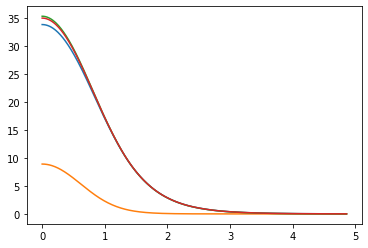

In [98]:
plt.plot(R,hfield)
plt.plot(R,Sfield-Sfield[-1])
plt.plot(R,-phi1d+phi1d[-1])
plt.plot(R,np.sqrt(hfield**2 + (Sfield-Sfield[-1])**2))

(array([411.,  10.,   8.,   7.,   7.,   7.,   8.,   8.,  10.,  25.]),
 array([1.08075386e-11, 1.54496824e-05, 3.08993541e-05, 4.63490257e-05,
        6.17986973e-05, 7.72483690e-05, 9.26980406e-05, 1.08147712e-04,
        1.23597384e-04, 1.39047056e-04, 1.54496727e-04]),
 <BarContainer object of 10 artists>)

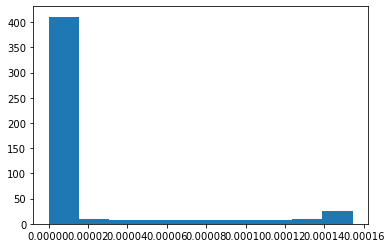

In [128]:
# Check whether the path is along the valley
Spathlist = m.A*(hfield**2 - 2*v*v + m.cs*m1d.Tn**2)/(2*m.muS2)
plt.hist(abs((Spathlist - Sfield)/Sfield))

The error is within 1/10000. So the path is basically along the valley.

In [129]:
output=np.array([R.tolist(),hfield.tolist(),Sfield.tolist()]).transpose().tolist()

In [130]:
import csv
csv_file_path = "./output/profile2d.csv"
with open(csv_file_path, "w") as f:
    data_writer = csv.writer(f)
    data_writer.writerows(output)

In [116]:
m.beta_over_H_at_Tn()

Path deformation converged. 26 steps. fRatio = 6.79722e-03
Path deformation converged. 19 steps. fRatio = 1.99184e-02
Path deformation converged. 5 steps. fRatio = 1.88743e-02
Path deformation converged. 1 steps. fRatio = 1.23982e-02
Path deformation converged. 26 steps. fRatio = 6.70609e-03
Path deformation converged. 19 steps. fRatio = 1.88230e-02
Path deformation converged. 5 steps. fRatio = 1.84837e-02
Path deformation converged. 1 steps. fRatio = 1.21421e-02
Path deformation converged. 26 steps. fRatio = 6.52483e-03
Path deformation converged. 19 steps. fRatio = 1.67639e-02
Path deformation converged. 5 steps. fRatio = 1.77256e-02
Path deformation converged. 1 steps. fRatio = 1.16004e-02
Path deformation converged. 26 steps. fRatio = 6.43497e-03
Path deformation converged. 17 steps. fRatio = 1.90933e-02
Path deformation converged. 5 steps. fRatio = 1.60911e-02
Path deformation converged. 1 steps. fRatio = 1.04976e-02


44440.04238790294

In [131]:
m1d.beta_over_H_at_Tn()

Path deformation converged. 1 steps. fRatio = 5.02258e-14
Path deformation converged. 1 steps. fRatio = 7.47043e-14
Path deformation converged. 1 steps. fRatio = 7.34591e-14
Path deformation converged. 1 steps. fRatio = 7.28568e-14


40440.79679299931